In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2024-09-06 16:29:14.602865: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-06 16:29:15.212896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-09-06 16:29:15.212975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-09-06 16:29:15.212983: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Opening BSCCM
Opened BSCCM


In [2]:
channel_name = 'LED119'
num_images = 5000
num_patches = num_images
patch_size = 16
edge_crop = 24

test_set_size = 2000

noise_seed = 1234
patches_seed = 1234567

images = load_bsccm_images(bsccm, channel_name, num_images=num_images, 
                            edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False, verbose=False, batch=1)
patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, verbose=False, seed=patches_seed)

noisy_patches = add_shot_noise_to_experimenal_data(patches, 0.2, seed=noise_seed)

train_set = noisy_patches[:noisy_patches.shape[0] - test_set_size]
test_set = noisy_patches[-test_set_size:]



## 1) Train N models

In [3]:
epochs = 10 # keep this low so theres at least some variation in the models

data_seed = 12345

N_models = 100
models = []
nlls = []

for i in tqdm(range(N_models)):
    model_seed = i
    model = PixelCNN()
    model.fit(train_set, model_seed=model_seed, data_seed=data_seed, max_epochs=epochs, verbose=False)
    models.append(model)
    nlls.append(model.compute_negative_log_likelihood(test_set, data_seed=data_seed, average=False))


  0%|          | 0/100 [00:00<?, ?it/s]2024-09-06 16:30:05.259235: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Evaluating NLL: 2000it [00:04, 481.14it/s]
Evaluating NLL: 2000it [00:03, 612.44it/s]41s/it]
Evaluating NLL: 2000it [00:03, 555.75it/s]s/it]  
Evaluating NLL: 2000it [00:03, 556.20it/s]s/it]
Evaluating NLL: 2000it [00:03, 619.12it/s]s/it]
Evaluating NLL: 2000it [00:03, 626.07it/s]s/it]
Evaluating NLL: 2000it [00:03, 632.15it/s]s/it]
Evaluating NLL: 2000it [00:03, 621.57it/s]s/it]
Evaluating NLL: 2000it [00:03, 581.70it/s]s/it]
Evaluating NLL: 2000it [00:03, 566.66it/s]s/it]
Evaluating NLL: 2000it [00:03, 624.68it/s]9s/it]
Evaluating NLL: 2000it [00:03, 629.20it/s]9s/it]
Evaluating NLL: 2000it [00:03, 548.87it/s]8s/it]
Evaluating NLL: 2000it [00:03, 623.81it/s]5s/it]
Evaluating NLL: 2000it [00:03, 623.92it/s]2s/it]
Evaluating NLL: 2000i

## Generate cumulative minimum curve for N models

Text(0, 0.5, 'Count')

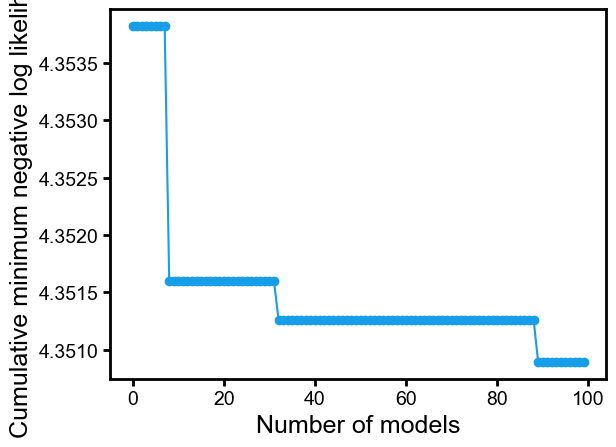

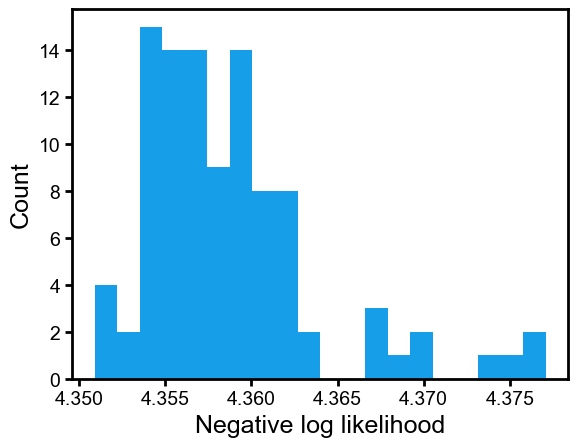

In [7]:
average_nlls = np.mean(np.array(nlls), axis=1)
cumulative_min = onp.minimum.accumulate(average_nlls)

# plot the cumulative minimum
fig, ax = plt.subplots()
ax.plot(cumulative_min, '-o')
ax.set_xlabel('Number of models')
ax.set_ylabel('Cumulative minimum negative log likelihood')


# plot histograms of the final nlls
fig, ax = plt.subplots()
_ = ax.hist(average_nlls, bins=20)
ax.set_xlabel('Negative log likelihood')
ax.set_ylabel('Count')

## Check the test set size needed

100%|██████████| 20/20 [00:00<00:00, 469.90it/s]


Text(0, 0.5, 'Average negative log likelihood')

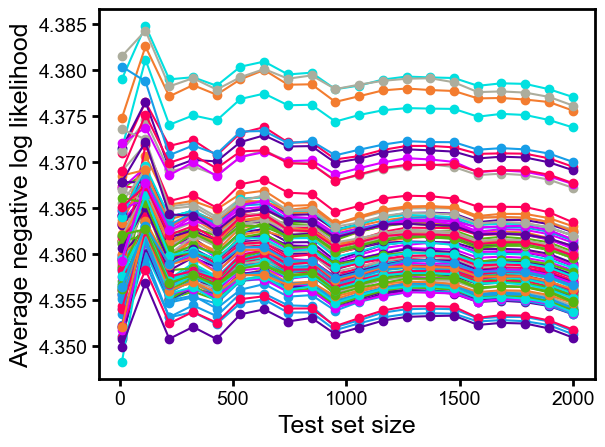

In [5]:
test_set_sizes = np.linspace(10, test_set.shape[0], 20).astype(int)

fig, ax = plt.subplots()

for i, (model, nll) in enumerate(zip(models, nlls)):
    partial_test_set_nlls = []
    for size in tqdm(test_set_sizes):
        partial_test_set_nlls.append(np.mean(nll[:size]))

    ax.plot(test_set_sizes, partial_test_set_nlls, '-o', label='Model {}'.format(i))

ax.set_xlabel('Test set size')
ax.set_ylabel('Average negative log likelihood')

## Bootstrap test set with best model to get variance of parameter vs dataset size

100%|██████████| 20/20 [00:00<00:00, 106.27it/s]


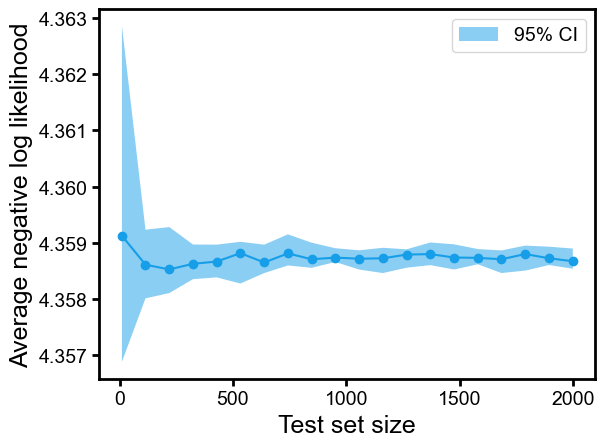

In [8]:
num_bootstrap_samples = 11


best_model = models[np.argmin(average_nlls)]

# for each test set size, draw a bootstrapped samples of the nlls
mean_nll_dist_by_size = []
for size in tqdm(test_set_sizes):
    # compute mean nll of a randomly sampled subset of the test set
    means = [onp.random.choice(average_nlls, size=size, replace=True).mean() for i in range(num_bootstrap_samples)]
    mean_nll_dist_by_size.append(means)

mean_nll_dist_by_size = np.array(mean_nll_dist_by_size)
conf_low = np.percentile(mean_nll_dist_by_size, 2.5, axis=1)
conf_high = np.percentile(mean_nll_dist_by_size, 97.5, axis=1)

# make a 95% confidence interval fill between
fig, ax = plt.subplots()
ax.plot(test_set_sizes, np.median(mean_nll_dist_by_size, axis=1), '-o')
ax.fill_between(test_set_sizes, conf_low, conf_high, alpha=0.5, label='95% CI')
ax.set_xlabel('Test set size')
ax.set_ylabel('Average negative log likelihood')
ax.legend()